<a href="https://colab.research.google.com/github/e-saidha/credit_card_fraud_detection/blob/main/features_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries & loading the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

print("Path to dataset files:", path)

100%|██████████| 145M/145M [00:01<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/priyamchoksi/credit-card-transactions-dataset/versions/1


In [3]:
import os
path1 = os.listdir(path)


In [4]:
df = pd.read_csv(f'{path}/{path1[0]}')

Velocity burst feauture engineering

Defining buckets

In [5]:
bins = [0, 1, 10, 50, 100, 500, 2000, 10000, df['amt'].max()]
labels = ['0–1', '1–10', '10–50', '50–100', '100–500', '500–2000', '2000–10k', '10k+']
df['amt_buck'] = pd.cut(df['amt'], bins=bins, labels=labels, include_lowest=True)


In [6]:
def time_bucket(h):
    if 0 <= h < 4:
        return 'Late Night'
    elif 4 <= h < 7:
        return 'Early Morning'
    elif 7 <= h < 12:
        return 'Morning'
    elif 12 <= h < 16:
        return 'Afternoon'
    elif 16 <= h < 20:
        return 'Evening'
    else:
        return 'Night'

In [7]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['hour_buck'] = df['hour'].apply(time_bucket)

Sorting all values as per cc

In [8]:
df = df.sort_values(['cc_num', 'trans_date_trans_time']).reset_index(drop=True)

In [9]:
df =df.set_index('trans_date_trans_time', drop=False)

In [10]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,amt_buck,hour,hour_buck
trans_date_trans_time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 12:47:15,1017,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,F,9886 Anita Drive,...,1986-02-17,98e3dcf98101146a577f85a34e58feec,1325422035,43.974711,-109.741904,0,NaN,1–10,12,Afternoon
2019-01-02 08:44:57,2724,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94,Mary,Diaz,F,9886 Anita Drive,...,1986-02-17,498120fc45d277f7c88e3dba79c33865,1325493897,42.018766,-109.044172,0,NaN,50–100,8,Morning
2019-01-02 08:47:36,2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08,Mary,Diaz,F,9886 Anita Drive,...,1986-02-17,95f514bb993151347c7acdf8505c3d62,1325494056,42.961335,-109.157564,0,NaN,50–100,8,Morning
2019-01-02 12:38:14,2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79,Mary,Diaz,F,9886 Anita Drive,...,1986-02-17,4f0c1a14e0aa7eb56a490780ef9268c5,1325507894,42.228227,-108.747683,0,NaN,10–50,12,Afternoon
2019-01-02 13:10:46,2907,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18,Mary,Diaz,F,9886 Anita Drive,...,1986-02-17,3b2ebd3af508afba959640893e1e82bc,1325509846,43.321745,-108.091143,0,82649.0,10–50,13,Afternoon


Creating rolling windows

In [11]:
df['txn_1h'] = df.groupby('cc_num')['trans_num'].rolling('60min').count().reset_index(level=0, drop=True)
df['txn_10min'] = df.groupby('cc_num')['trans_num'].rolling('10min').count().reset_index(level=0, drop=True)
df['txn_24h'] = df.groupby('cc_num')['trans_num'].rolling('24h').count().reset_index(level=0, drop=True)
df['avg_amt'] = df.groupby('cc_num')['amt'].rolling(window=10, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df = df.reset_index(drop=True)

In [12]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,merch_long,is_fraud,merch_zipcode,amt_buck,hour,hour_buck,txn_1h,txn_10min,txn_24h,avg_amt
0,1017,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,F,9886 Anita Drive,...,-109.741904,0,NaN,1–10,12,Afternoon,1.0,1.0,1.0,NaN
1,2724,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94,Mary,Diaz,F,9886 Anita Drive,...,-109.044172,0,NaN,50–100,8,Morning,1.0,1.0,2.0,7.270
2,2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08,Mary,Diaz,F,9886 Anita Drive,...,-109.157564,0,NaN,50–100,8,Morning,2.0,2.0,3.0,30.105
3,2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79,Mary,Diaz,F,9886 Anita Drive,...,-108.747683,0,NaN,10–50,12,Afternoon,1.0,1.0,4.0,47.430
4,2907,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18,Mary,Diaz,F,9886 Anita Drive,...,-108.091143,0,82649.0,10–50,13,Afternoon,2.0,1.0,4.0,44.270


In [13]:
print(df[['txn_10min','txn_1h','txn_24h','avg_amt']].describe().round(2))


        txn_10min      txn_1h     txn_24h     avg_amt
count  1296675.00  1296675.00  1296675.00  1296674.00
mean         1.03        1.19        4.88       70.30
std          0.18        0.46        3.08       59.34
min          1.00        1.00        1.00        1.03
25%          1.00        1.00        3.00       42.83
50%          1.00        1.00        4.00       58.52
75%          1.00        1.00        6.00       80.20
max          4.00        7.00       36.00     2986.68


In [14]:
df.groupby('cc_num')['txn_10min'].max().sort_values(ascending=False).head(10)

,txn_10min
cc_num,
2242542703101233,4.0
3521417320836166,4.0
630424987505,4.0
3518758680062249,4.0
346273234529002,4.0
372520049757633,4.0
3540862542587229,4.0
3551217896304745,4.0
342360239917375,4.0


Diagnostic

In [15]:
card_id = 3566875419572867
card_df = df[df['cc_num'] == card_id][['trans_date_trans_time', 'amt', 'txn_10min', 'txn_1h', 'txn_24h', 'is_fraud']]
card_df.sort_values('txn_10min',ascending=False)[['txn_10min','is_fraud']]

,txn_10min,is_fraud
760245,4.0,1
760244,3.0,1
760135,2.0,0
760252,2.0,1
759932,2.0,0
...,...,...
759623,1.0,0
759624,1.0,0
759625,1.0,0
759626,1.0,0


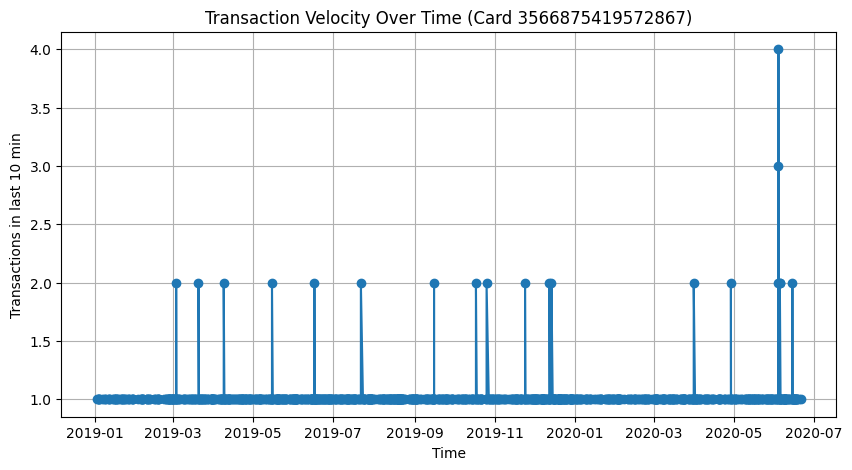

In [16]:
plt.figure(figsize=(10,5))
plt.plot(card_df['trans_date_trans_time'], card_df['txn_10min'], marker='o')
plt.title(f'Transaction Velocity Over Time (Card {card_id})')
plt.xlabel('Time')
plt.ylabel('Transactions in last 10 min')
plt.grid(True)
plt.show()


In [17]:
fraud_rate = df.groupby('txn_10min')['is_fraud'].mean()
print(fraud_rate)

txn_10min
1.0    0.005261
2.0    0.020896
3.0    0.065482
4.0    0.212121
Name: is_fraud, dtype: float64


Geolocation feature engineering

In [18]:
def haversine(lat1,lon1,lat2,lon2):
  R=6371
  lat1,lon1,lat2,lon2 = map(np.radians, [lat1,lon1,lat2,lon2])
  dlat = lat2-lat1
  dlon = lon2-lon1
  a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
  return 2 * R * np.arcsin(np.sqrt(a))

In [19]:
df = df.sort_values(['cc_num', 'trans_date_trans_time']).reset_index(drop=True)

df['prev_merch_lat'] = df.groupby('cc_num')['merch_lat'].shift(1)
df['prev_merch_long'] = df.groupby('cc_num')['merch_long'].shift(1)
df['prev_time'] = df.groupby('cc_num')['trans_date_trans_time'].shift(1)

df['dist_km'] = haversine(df['prev_merch_lat'], df['prev_merch_long'],
                          df['merch_lat'], df['merch_long'])

In [20]:
df['time_diff_sec'] = (df['trans_date_trans_time'] - df['prev_time']).dt.total_seconds()


In [21]:
df['speed_kmph'] = df['dist_km'] / (df['time_diff_sec'] / 3600)


In [22]:
df['dist_km'] = df['dist_km'].fillna(0)
df['speed_kmph'] = df['speed_kmph'].replace([np.inf, -np.inf], np.nan).fillna(0)


In [23]:
df[['speed_kmph','dist_km']].describe()



,speed_kmph,dist_km
count,1.296675e+06,1.296675e+06
mean,1.890182e+02,1.035159e+02
std,3.796555e+03,5.046020e+01
min,0.000000e+00,0.000000e+00
25%,7.579545e+00,6.428627e+01
50%,1.998657e+01,1.007226e+02
75%,5.870890e+01,1.396718e+02
max,7.806232e+05,2.859922e+02


In [24]:
df.sort_values('speed_kmph', ascending=False).head(10)[
    ['cc_num','trans_date_trans_time','dist_km','time_diff_sec','speed_kmph','is_fraud']
]


,cc_num,trans_date_trans_time,dist_km,time_diff_sec,speed_kmph,is_fraud
1093433,6011367958204270,2020-03-03 14:19:38,216.839773,1.0,780623.181548,0
142353,4561892980175,2019-11-27 09:52:48,196.176908,1.0,706236.867524,0
370246,213148039875802,2019-09-20 00:25:18,195.177669,1.0,702639.608782,0
448490,348789608637806,2020-05-26 02:40:19,183.272698,1.0,659781.713288,0
330402,180048185037117,2019-05-27 16:03:41,181.531315,1.0,653512.735698,0
1292456,4973530368125489546,2019-08-06 08:06:05,174.726407,1.0,629015.065183,0
659924,3525590521269779,2019-12-08 13:31:13,171.491848,1.0,617370.654240,0
589946,2706977570537524,2019-03-11 08:35:17,171.108272,1.0,615989.779014,0
252896,30371006069917,2019-04-28 00:12:52,166.236437,1.0,598451.171422,1
74291,675990301623,2019-05-07 16:44:15,162.291361,1.0,584248.899247,0


Creating Flags

In [25]:
df['flag_impossible_travel'] = (df['speed_kmph'] > 1000).astype(int)
df['flag_long_distance'] = (df['dist_km'] > 100).astype(int)
df['flag_velocity_burst'] = (df['txn_10min'] >= 3).astype(int)
flag_summary = df.groupby(['flag_impossible_travel','flag_long_distance','flag_velocity_burst'])['is_fraud'].mean()
print(flag_summary.sort_values(ascending=False))


flag_impossible_travel  flag_long_distance  flag_velocity_burst
1                       1                   1                      0.073218
0                       0                   1                      0.069124
1                       0                   1                      0.067449
0                       1                   1                      0.040000
1                       0                   0                      0.022628
                        1                   0                      0.020383
0                       0                   0                      0.005695
                        1                   0                      0.005190
Name: is_fraud, dtype: float64
